# Setup

## Import Library

In [11]:
import os
import asyncio
import importlib
import time
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import torch
import torchvision.models as models

# Cek GPU

In [4]:
print(torch.cuda.is_available())

False


# EDA

## Jumlah data

In [7]:
def count_images_in_folder(folder_path):
    """Menghitung jumlah gambar dalam folder dan subfolder."""
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]) 
    return count

# Path ke folder datasets
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung jumlah gambar di folder training
training_count = count_images_in_folder(training_path)
print(f"Jumlah gambar di folder training: {training_count}")

# Total jumlah gambar di folder testing
total_testing_count = count_images_in_folder(testing_path)
print(f"Jumlah gambar di folder testing: {total_testing_count}")

Jumlah gambar di folder training: 7354
Jumlah gambar di folder testing: 1646


## Distribusi datasets

Distribusi dataset untuk training: {'print': 2450, 'replay': 2640, 'real': 2264}


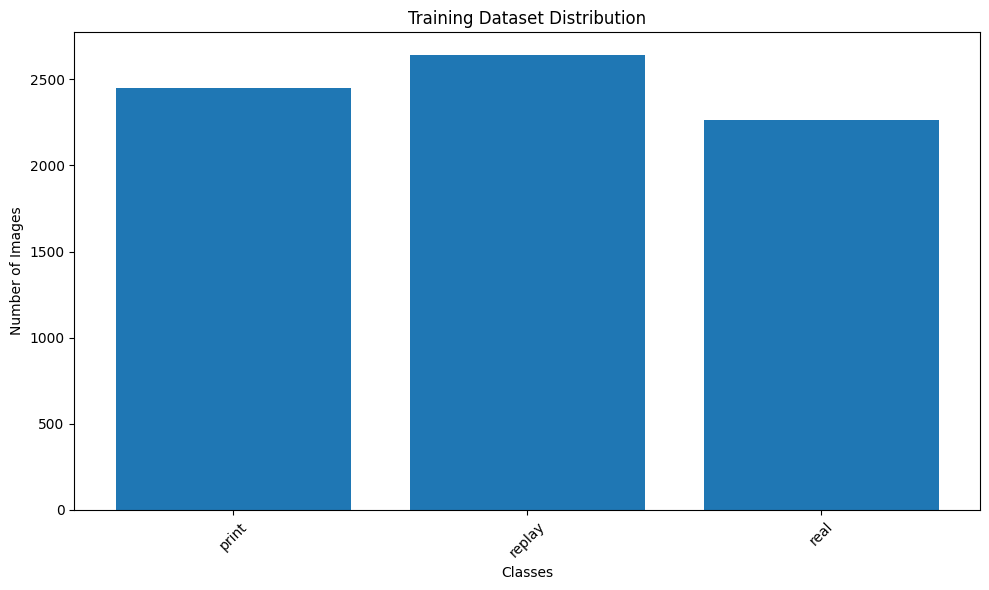

Distribusi dataset untuk testing: {'replay': 360, 'real': 736, 'print': 550}


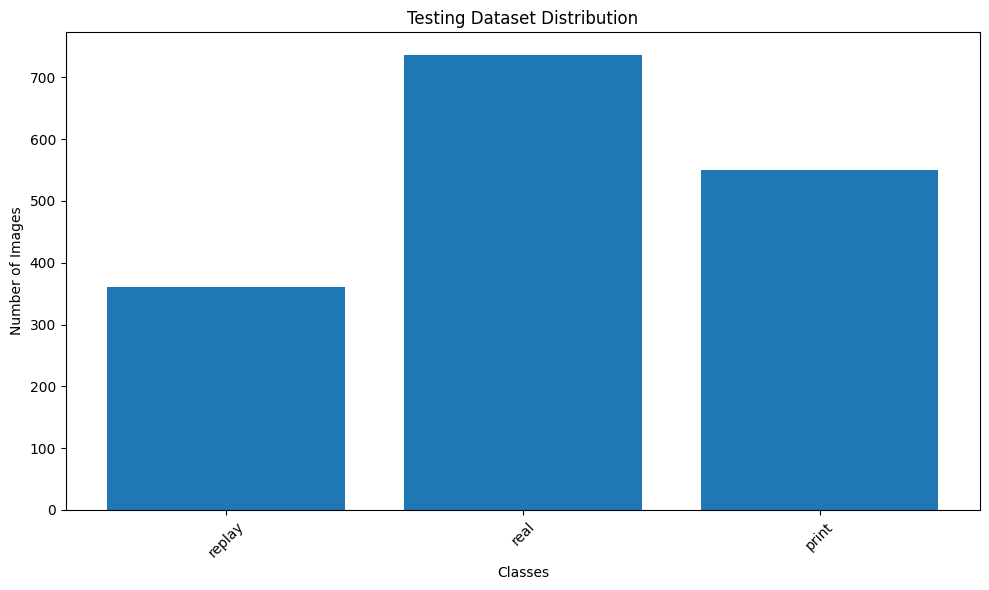

In [8]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder (kelas)
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung distribusi kelas untuk training
training_class_counts = count_images_in_classes(training_path)
print(f"Distribusi dataset untuk training: {training_class_counts}")
plot_distribution(training_class_counts, "Training Dataset Distribution")

# Hitung distribusi kelas untuk testing
testing_class_counts = count_images_in_classes(testing_path)
print(f"Distribusi dataset untuk testing: {testing_class_counts}")
plot_distribution(testing_class_counts, "Testing Dataset Distribution")

## Preview datasets

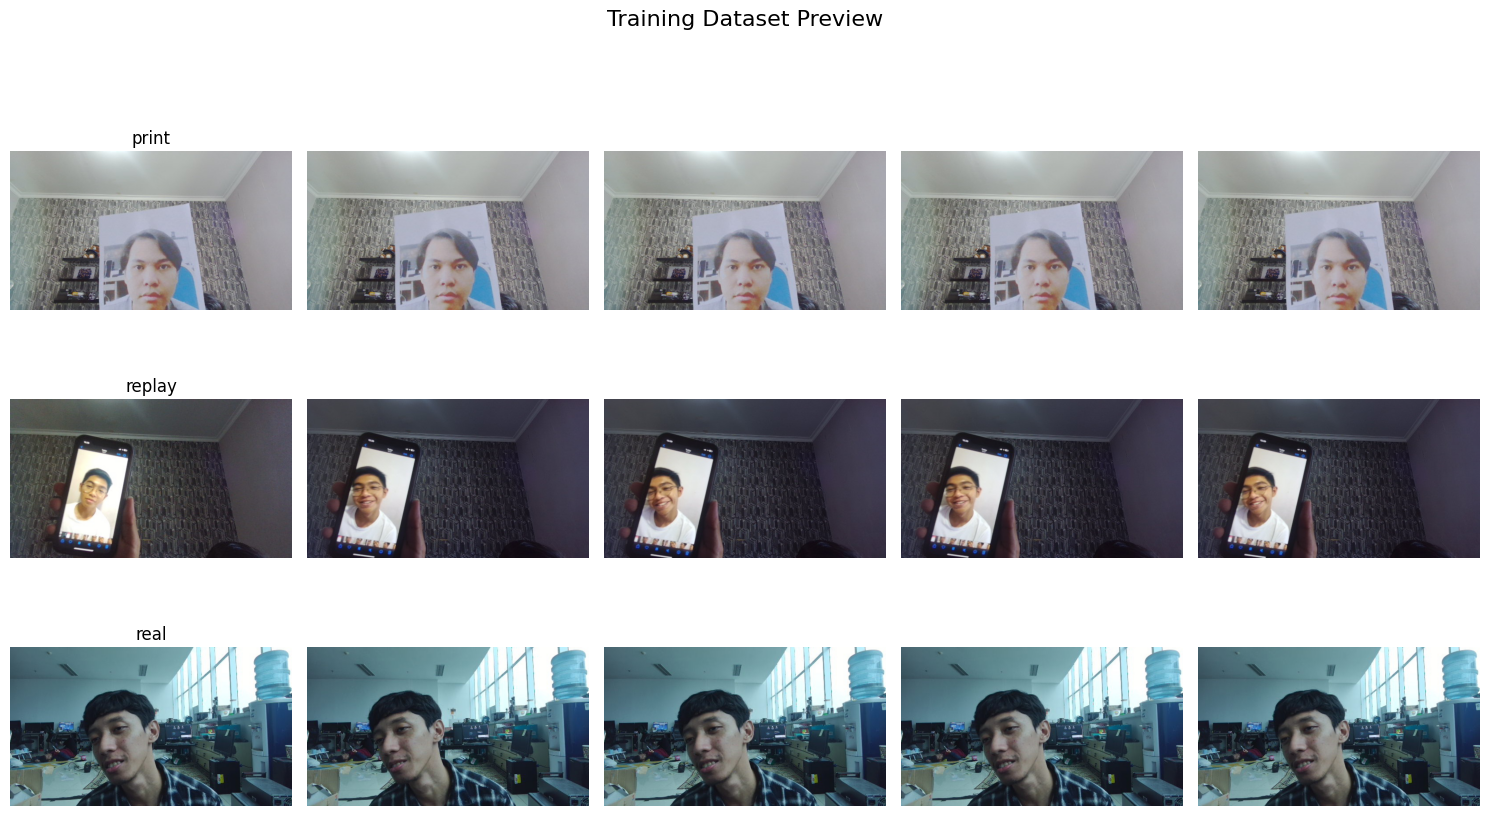

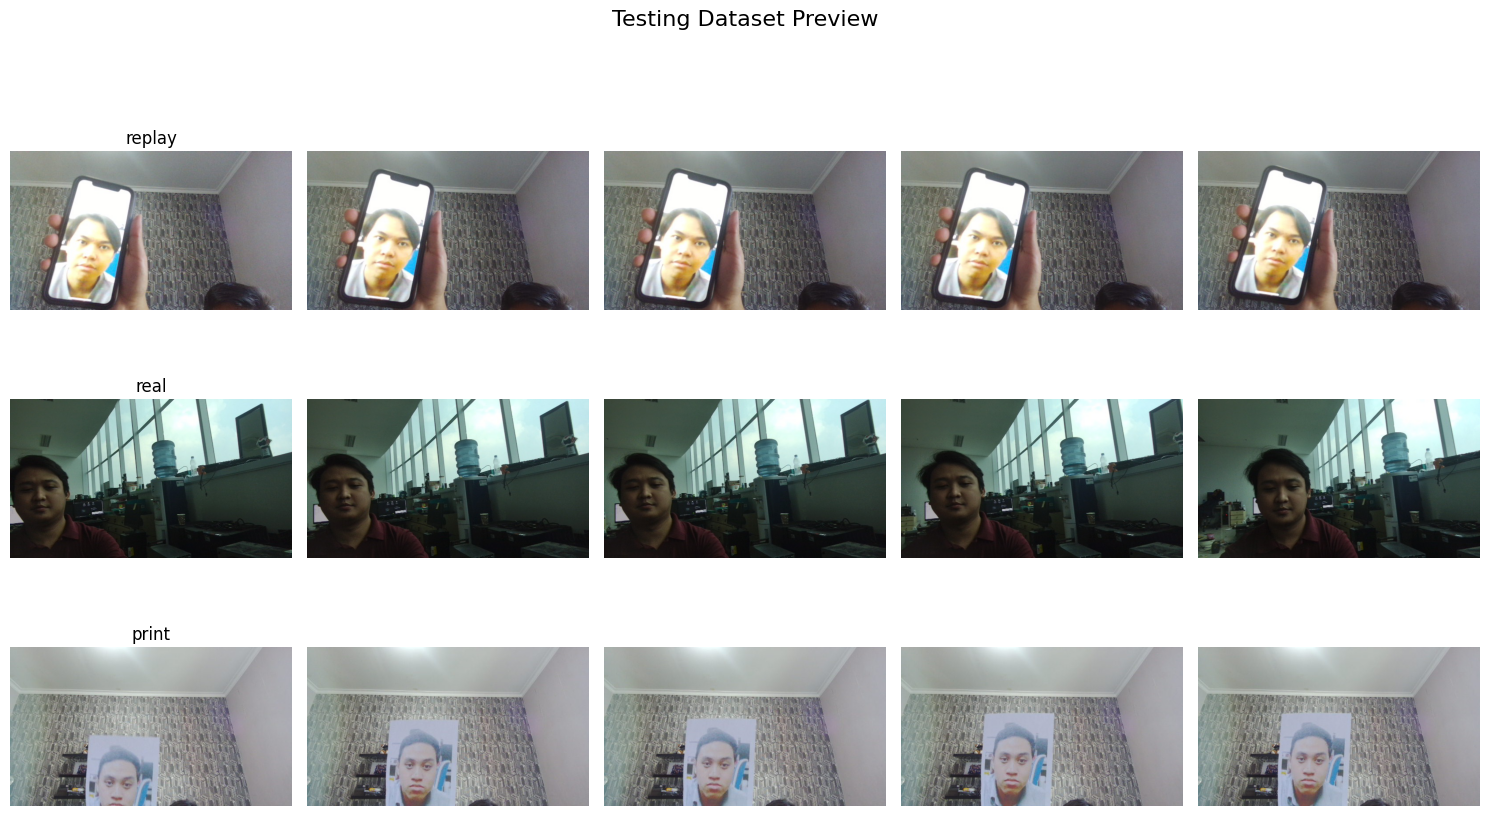

In [9]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        sample_images = images[:samples_per_class]  # Ambil sejumlah gambar untuk preview

        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Preview gambar di folder training
preview_images(training_path, "Training Dataset Preview", samples_per_class=5)

# Preview gambar di folder testing
preview_images(testing_path, "Testing Dataset Preview", samples_per_class=5)

# EfficientNetV2

In [12]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model EfficientNetV2 dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2_Small": models.efficientnet_v2_s(weights='IMAGENET1K_V1'),
    "EfficientNetV2_Medium": models.efficientnet_v2_m(weights='IMAGENET1K_V1'),
    "EfficientNetV2_Large": models.efficientnet_v2_l(weights='IMAGENET1K_V1'),
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/machi/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100.0%
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /home/machi/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100.0%
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /home/machi/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100.0%


,Model,Parameter Count
0,EfficientNetV2_Small,21.458.488
1,EfficientNetV2_Medium,54.139.356
2,EfficientNetV2_Large,118.515.272


# Swin Transformer

In [15]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model Swin Transformer dan menghitung jumlah parameternya
list_models = {
    "Swin-Tiny": models.swin_t(weights="IMAGENET1K_V1"),
    "Swin-Small": models.swin_s(weights="IMAGENET1K_V1"),
    "Swin-Base": models.swin_b(weights="IMAGENET1K_V1")
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,Swin-Tiny,28.288.354
1,Swin-Small,49.606.258
2,Swin-Base,87.768.224
